In [2]:
import os
import pandas as pd
from datetime import datetime, timedelta
from typing import List
from pathlib import Path
import bt
from nifty_index import NIFTY_OIL_GAS as index_stocks

In [3]:
print(index_stocks)

['ADANIGREEN', 'ADANITRANS', 'BPCL', 'CASTROLIND', 'GAIL', 'GUJGASLTD', 'HINDPETRO', 'IGL', 'INDRAPRASTH', 'IOC', 'MGL', 'ONGC', 'OIL', 'PETRONET', 'RELIANCE']


In [4]:
def load_signal_data(signal_dir: str = "../signal/se/equity", index_stocks: list = None) -> pd.DataFrame:
    """
    Loads all CSV signal files from the given directory (recursively),
    filters to include only index stock signals, and returns a cleaned DataFrame.
    
    Args:
        signal_dir (str): Path to the folder containing signal files.
        index_stocks (list): List of index stock symbols to filter. If None, loads all.

    Returns:
        pd.DataFrame: Combined signal DataFrame for index stocks.
    """
    signal_data = []
    signal_dir = Path(signal_dir)

    for file in signal_dir.rglob("*.csv"):
        try:
            df = pd.read_csv(file)
            if 'Symbol' in df.columns and not df.empty:
                df['Date'] = pd.to_datetime(df['Date'])
                signal_data.append(df)
        except Exception as e:
            print(f"❌ Failed to load {file}: {e}")

    if not signal_data:
        raise ValueError("No valid signal files found!")

    # Concatenate and clean
    full_df = pd.concat(signal_data, ignore_index=True)
    full_df.drop_duplicates(subset=["Date", "Symbol"], inplace=True)

    # Filter for index stocks
    if index_stocks is not None:
        full_df = full_df[full_df['Symbol'].isin(index_stocks)]

    # Sort for time-series logic
    full_df.sort_values(by=["Date", "Symbol"], inplace=True)

    # Optional: select only required columns
    final_cols = ['Date', 'Symbol', 'Signal']
    available_cols = [col for col in final_cols if col in full_df.columns]
    return full_df[available_cols].reset_index(drop=True)


In [5]:
def load_price_data(signal_df: pd.DataFrame, index_stocks: List[str], data_dir: str = "../data/nse/equity") -> pd.DataFrame:
    """
    Load raw price data for only the dates and index stocks relevant to the signal DataFrame.

    Args:
        signal_df (pd.DataFrame): DataFrame with 'Date' column to extract required dates.
        index_stocks (List[str]): List of index stock symbols to filter.
        data_dir (str): Path to the root data directory containing year/date-based .csv.gz files.

    Returns:
        pd.DataFrame: Pivoted DataFrame with Date as index, Symbol as columns, Close price as values.
    """
    needed_dates = pd.to_datetime(signal_df['Date'].unique()).strftime('%Y%m%d')
    needed_years = set(date[:4] for date in needed_dates)

    all_prices = []

    for year in needed_years:
        year_path = Path(data_dir) / year
        if not year_path.exists():
            continue

        for date_str in needed_dates:
            if not date_str.startswith(year):
                continue

            file_path = year_path / f"{date_str}.csv.gz"
            if not file_path.exists():
                continue
            try:
                df = pd.read_csv(file_path, compression='gzip')
                df = df[df['TckrSymb'].isin(index_stocks)]
                df = df[['TradDt', 'TckrSymb', 'ClsPric']]
                df.columns = ['Date', 'Symbol', 'Close']
                df['Date'] = pd.to_datetime(df['Date'])

                # Remove duplicates if any
                df.drop_duplicates(subset=['Date', 'Symbol'], inplace=True)
                                            
                all_prices.append(df)
            except Exception as e:
                print(f"⚠️ Error loading {file_path}: {e}")

    if not all_prices:
        raise ValueError("No valid price data found for the selected dates.")

    # Combine and pivot
    price_df = pd.concat(all_prices, ignore_index=True)
    price_df.sort_values(['Date', 'Symbol'], inplace=True)

    pivot = price_df.pivot(index='Date', columns='Symbol', values='Close')

    return pivot.sort_index()

In [6]:
def signals_to_weights(signal_df: pd.DataFrame, price_df: pd.DataFrame) -> pd.DataFrame:
    signal_df = signal_df.copy()

    # ✅ Ensure 'Date' is a column
    if 'Date' not in signal_df.columns:
        if signal_df.index.name == 'Date':
            signal_df = signal_df.reset_index()
        else:
            raise ValueError("🚨 'Date' not found in signal_df columns or index.")

    # Step 1: Normalize and shift by 1 day
    signal_df['Date'] = pd.to_datetime(signal_df['Date']).dt.normalize()
    signal_df['Date'] = signal_df['Date'] + pd.Timedelta(days=1)

    # Step 2: Pivot to [Date x Symbol]
    signal_pivot = signal_df.pivot(index='Date', columns='Symbol', values='Signal')

    # Step 3: Reindex to match price DataFrame index and fill missing with 'Hold'
    price_index = pd.to_datetime(price_df.index).normalize()
    signal_pivot = signal_pivot.reindex(price_index).fillna('Hold')

    # Step 4: Normalize text and map to weights
    signal_map = {'buy': 1.0, 'sell': -1.0, 'hold': 0.0}
    weight_df = signal_pivot.map(lambda x: signal_map.get(str(x).strip().lower(), 0.0))
    # Ensure columns match price_df
    weight_df = weight_df.reindex(columns=price_df.columns, fill_value=0.0)

    # Step 5: Ensure final weights index matches price_df
    weight_df.index = price_df.index

    return weight_df


In [7]:
def run_backtest(price_df: pd.DataFrame, weight_df: pd.DataFrame, initial_capital: int = 1_000_000):

    # Setup strategy
    strategy = bt.Strategy(
        'BuyHoldSellStrategy',
        [
            bt.algos.RunDaily(),
            bt.algos.SelectAll(),
            bt.algos.WeighTarget(weight_df),  
            bt.algos.Rebalance()
        ]
    )
   
    # Run backtest
    backtest = bt.Backtest(strategy, price_df, initial_capital=initial_capital)
    result = bt.run(backtest)
    return result


In [8]:
signal_dir = "../signal/nse/equity"
data_dir = "../data/nse/equity"
capital = 1000000

HOLDING_DAYS = 5

📥 Loading signal data...
💰 Preparing price data...
📊 Converting signals to weights...
Price Columns: ['ADANIGREEN', 'BPCL', 'CASTROLIND', 'GAIL', 'GUJGASLTD', 'HINDPETRO', 'IGL', 'IOC', 'MGL', 'OIL', 'ONGC', 'PETRONET', 'RELIANCE']
Weight Columns: ['ADANIGREEN', 'BPCL', 'CASTROLIND', 'GAIL', 'GUJGASLTD', 'HINDPETRO', 'IGL', 'IOC', 'MGL', 'OIL', 'ONGC', 'PETRONET', 'RELIANCE']
Price Dates: 2025-01-20 00:00:00 to 2025-09-12 00:00:00
Weight Dates: 2025-01-20 00:00:00 to 2025-09-12 00:00:00
Symbol      ADANIGREEN  BPCL  CASTROLIND  GAIL  GUJGASLTD  HINDPETRO  IGL  \
Date                                                                        
2025-01-20         0.0   0.0         0.0   0.0        0.0        0.0  0.0   
2025-01-21        -1.0  -1.0        -1.0  -1.0       -1.0        0.0 -1.0   
2025-01-22        -1.0  -1.0         0.0  -1.0       -1.0       -1.0 -1.0   
2025-01-23        -1.0  -1.0         0.0  -1.0       -1.0       -1.0  0.0   
2025-01-24        -1.0  -1.0         0.0  -1.0

100%|███████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 22.77it/s]

📈 Backtest complete.
Stat                 BuyHoldSellStrategy
-------------------  ---------------------
Start                2025-01-19
End                  2025-09-12
Risk-free rate       0.00%

Total Return         190.65%
Daily Sharpe         1.90
Daily Sortino        4.31
CAGR                 421.37%
Max Drawdown         -55.32%
Calmar Ratio         7.62

MTD                  -29.83%
3m                   -4.66%
6m                   -42.44%
YTD                  190.65%
1Y                   -
3Y (ann.)            -
5Y (ann.)            -
10Y (ann.)           -
Since Incep. (ann.)  421.37%

Daily Sharpe         1.90
Daily Sortino        4.31
Daily Mean (ann.)    237.52%
Daily Vol (ann.)     124.84%
Daily Skew           2.35
Daily Kurt           11.72
Best Day             49.18%
Worst Day            -21.08%

Monthly Sharpe       0.79
Monthly Sortino      4.29
Monthly Mean (ann.)  161.50%
Monthly Vol (ann.)   204.22%
Monthly Skew         1.99
Monthly Kurt         3.75
Best Month       

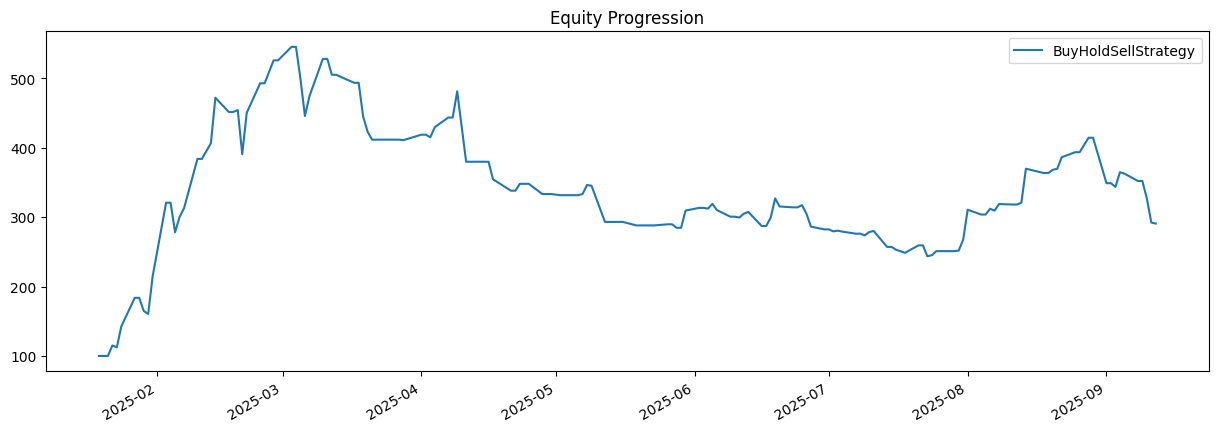

In [9]:
print("📥 Loading signal data...")
signals = load_signal_data(signal_dir, index_stocks)

print("💰 Preparing price data...")
prices = load_price_data(signals, index_stocks, data_dir)

print("📊 Converting signals to weights...")
weights = signals_to_weights(signals, prices)
print("Price Columns:", prices.columns.tolist())
print("Weight Columns:", weights.columns.tolist())
print("Price Dates:", prices.index.min(), "to", prices.index.max())
print("Weight Dates:", weights.index.min(), "to", weights.index.max())
print(weights.head())

print("🚀 Running backtest...")
results = run_backtest(prices, weights, capital)

print("📈 Backtest complete.")
results.plot()
results.display()